In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import grad, jit
from jax.nn import softmax
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model import HGF
from pytensor.graph import Apply, Op

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise

In [2]:
timeserie = load_data("continuous")

### Making a baseline network to compare the node structures

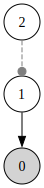

In [3]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

# Input data
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(
    input_data=timeserie
)

# Visualize the model structure
two_levels_continuous_hgf.plot_network()

### Visualize the node states

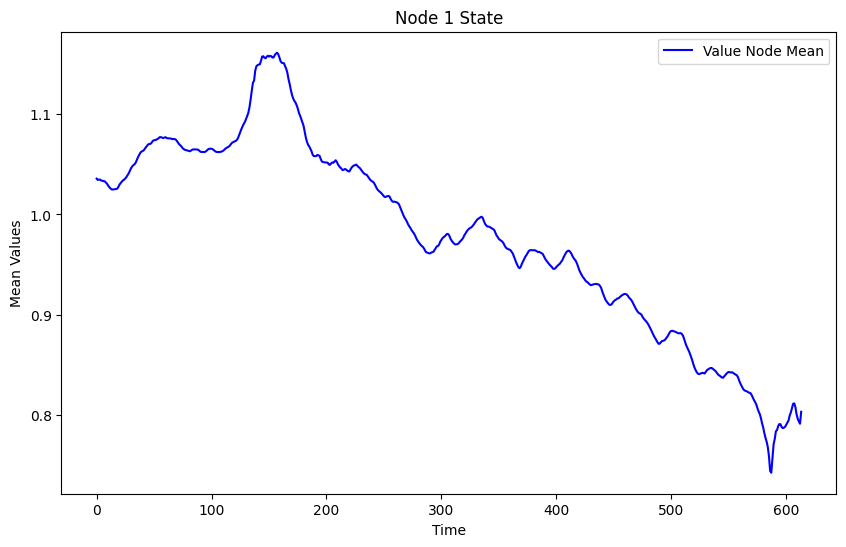

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(
    two_levels_continuous_hgf.node_trajectories[1]['mean'],
    label='Value Node Mean',
    color='blue'
)
plt.title('Node 1 State')
plt.xlabel('Time')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

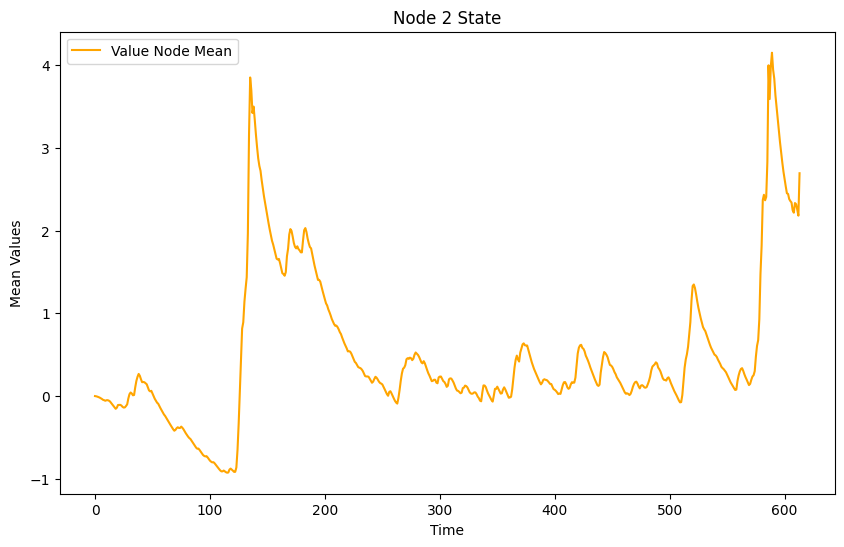

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(
    two_levels_continuous_hgf.node_trajectories[2]['mean'],
    label='Value Node Mean',
    color='orange'
)
plt.title('Node 2 State')
plt.xlabel('Time')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

### Now we create our newly created "implicit" volatility node

In [6]:
# Create network with new node type
network = (
    Network()
    .add_nodes(precision=1e4)  # Input node
    .add_nodes(
        kind="value-volatility",
        precision=1e4,
        mean=timeserie[0],
        tonic_volatility=-13.0,
        precision_vol=1e1,
        tonic_volatility_vol=-2.0,
        volatility_coupling_internal=1.0,
        value_children=0
    )
)

# And pass some data in it
network = network.input_data(input_data=timeserie)

### Now we visualize the node states, as with previous network

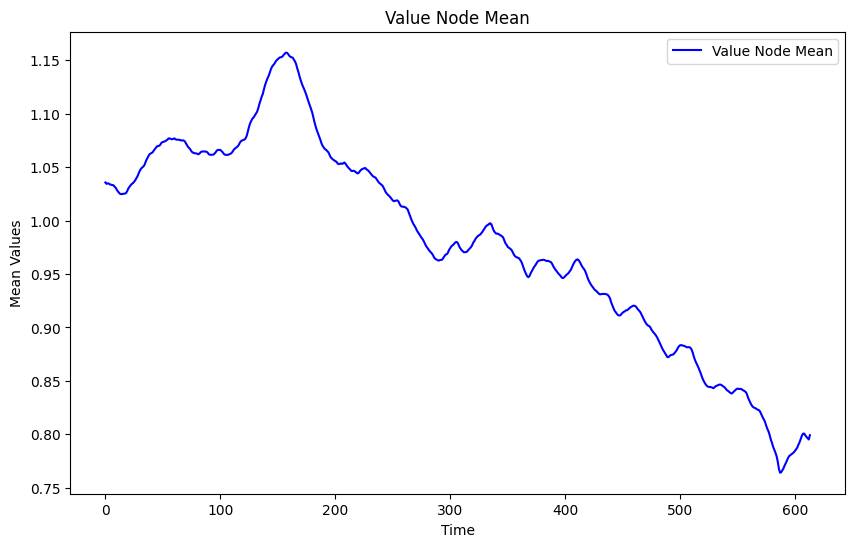

In [7]:
# Value node trajectory
plt.figure(figsize=(10, 6))
plt.plot(
    network.node_trajectories[1]['mean'],
    label='Value Node Mean',
    color='blue'
)
plt.title('Value Node Mean')
plt.xlabel('Time')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

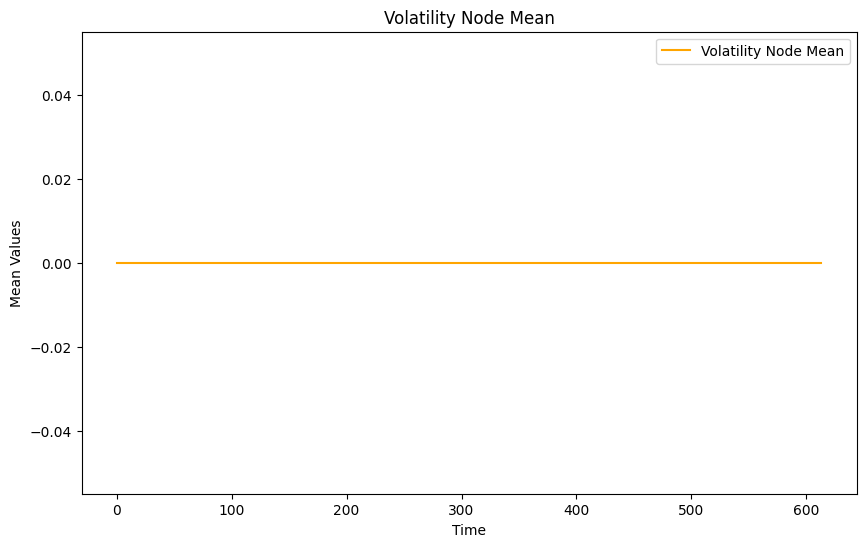

In [8]:
# Volatility node trajectory
plt.figure(figsize=(10, 6))
plt.plot(
    network.node_trajectories[1]['mean_vol'],
    label='Volatility Node Mean',
    color='orange'
)
plt.title('Volatility Node Mean')
plt.xlabel('Time')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

In [9]:
network.node_trajectories[1]['mean_vol']

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [11]:
# After running input_data, check:
print("Input node PE:",
network.node_trajectories[0]['val_prediction_error'][:10])
print("VV node volatility PE:",
network.node_trajectories[1]['vol_prediction_error'][:10])

KeyError: 'val_prediction_error'